In [1]:
import numpy as np 
from matplotlib import pyplot as plt

# To render plots inside the Jupyter notebook
%matplotlib inline

# Python language and Jupyter notebooks

For the hands-on exercises accompanying the lectures on exoplanets, we'll use the Python programming 
language together with popular libraries for scientific computing such as 
[Numpy](https://docs.scipy.org/doc/numpy/reference/) and [matplotlib](https://matplotlib.org/3.1.1/index.html), 
as well as cutting edge astrophysical software such as [REBOUND](https://rebound.readthedocs.io/en/latest/) and
[Starry](https://rodluger.github.io/starry/v0.3.0/). If you're unfamiliar with programming in Python, I highly recommend
the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) free online book which was written
by an ex astronomer (now data scientist at Google) Jake VanderPlas. Each chapter is a stand-alone Jupyter notebook 
and is quite short.

We'll do all of the coding in [Jupyter Notebooks](https://jupyter.org/). Think of Jupyter notebooks as regular Python code, 
except intermixed with rich text (including LaTeX) and code output such as plots. Jupyter notebooks are ideal for 
quickly hacking on a project and seeing the results immediately but you probably shouldn't use them for larger projects.
A Jupyter notebook consists of a series of cells, executed seqentially. The cells can either be text cells (such as this one)
or code cells. To execute a cell, press `Shift + Enter` on your keyboard. To change the type of the cell from a text 
(Markdown) cell to a code cell click on the left side of the cell and press `y` on the keyboard, to go back to a Markdown
cell press `m`, you can also use the drop down menu. Jupyter notebooks allow you to execute code non-sequentially, this is
generally considered to be bad practice and can give you headaches. Thus, whenever you want to execute the code, 
go to the drop down menu, click on `Kernel` and `Restart and Run All Cells`, this command will execute all cells in
a sequence.

Although you can run Jupyter notebooks locally on your computer we'll use Jupyter notebooks online using 
[Binder](https://gke.mybinder.org/) to avoid having to deal with issues around installing Python on different machines.
All you need is to run Jupyter notebooks on the cloud is a web browser and a decent internet connection. If you do 
want to run Jupyter notebooks on your local machine, I recommend installing Python via 
[Anaconda](https://www.anaconda.com/distribution/) and setting up a 
[conda environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).




# N-BODY simulations and the REBOUND code

The *N-body problem* is a problem of solving for the dynamics of $N$ gravitationally interacting
masses. The equations of motion are given by
$$
    m_i\ddot{\mathbf{r}}_i=\sum_{j=1,j\neq 1}^NGm_im_j \frac{\mathbf{r}_{ij}}
    {\lvert \mathbf{r}_{ij}\rvert^3} 
$$
where $m_i$ is the mass of the $i$-th particle, $\mathbf{r}_i$ is its 
position vector, $\mathbf{r}_{ij}=\mathbf{r}_j-\mathbf{r}_i$ and $i=1\dots N$.
Once the initial positions $\mathbf{r}_{i,0}$ and velocities $\dot{\mathbf{r}}_{i,0}$
are specified, there exists a unique solution which can only be obtained
numerically for $N>2$. The N-body system of equations is extremely sensitive
to the initial conditions and special care must be taken to ensure numerical
accuracy of the solutions. Since  the equations involve the calculation of force
between each pair of particles and there are $N(N-1)/2$ total pairs, the 
computational complexity of the problem scales as $\mathcal{O}(N^2)$. 

There are many different ways of solving these equations numerically,
and the choice of method depends primarily on the problem at hand. For systems
with large $N$
approximation schemes are often used which manage to reduce the complexity
to order $\mathcal{O}(N\ln N)$. In celestial mechanics $N$ is generally on
the order of a few and the integration times are very long (sometimes 
billions of years), very high precision is thus needed. 
Another difficulty is the fact that the equations of motion
has a singularity when two particles come very close to each other which
can lead to arbitrarily high particle velocities if not properly handled.
For a system of $N$ gravitationally interacting bodies the total energy 
and angular momentum are always conserved, however, this need not be true 
for a numerical solution of the equations of motion. Often, the 'quality'
of an integrator (a numerical scheme which solves a system of differential
equations) is judged by how well it conserves the total energy.

Because the N-body problem occurs very often in astrophysical applications,
there exist multiple numerical solvers for problems of various scales and 
with varying degree of accuracy. For the problem of simulating a dynamics of 
exoplanetary systems we'll use the [REBOUND](https://github.com/hannorein/rebound) 
code. REBOUND is a state of the art code written in C with a Python interface and
excellent documentation. REBOUND comes with many integrators, the most important of which
are the hybrid integrator MERCURIUS and an adaptive very high-order integrator
`IAS15`.

These integrators are designed to solve a system of differential equations of the form
$$
\ddot{\mathbf{y}}(t)=F(\dot{\mathbf{y}},\mathbf{y},t)
    \label{eq:diff_eq}
$$
where $\ddot{\mathbf{y}}$ is the acceleration and $F$ is an arbitrary force
which may depend also on the velocity. 

## Integrating the two body problem with REBOUND

The fundamental objectin REBOUND is the `Simulation` object. It stores the positions 
and velocities of all the particles involved in a simulation

In [2]:
import rebound

sim = rebound.Simulation()

In [3]:
type(sim) # check object type

rebound.simulation.Simulation

By default REBOUND uses units where the gravitational constant $G$ is equal to unity, $G=1$. 
For example, if the distances are expressed in Astronomical Units $AU$, masses in solar masses $M_\odot$
and time is in $yr/2\pi$. To specify the orbits of each of the bodies we want to add to the `Simulation` 
object, REBOUND uses Jacobi coordinates:

![Jacobi coordinates](https://i.ibb.co/2NqrGGp/Screenshot-2019-07-16-at-18-04-46.png)

In Jacobi coordinates, the orbit of the each additional $N+1$ body is specified with respect to the 
centre of mass of the inner $N$ bodies. You can override this behaviour by passing the keyword 
`primary=` when adding an additional body. 

Let's add two bodies to the simulation and integrate it for some time.

In [4]:
sim.add(m=1) # Add a 1 Solar Mass star
sim.add(m=0.05, e=0.3, a=0.4) # a is specified relative to the star

sim.status() # get info on all particles in the simulation

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul  9 2019 15:23:25
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=0.05 x=0.28 y=0.0 z=0.0 vx=0.0 vy=2.207940216581962 vz=0.0>
---------------------------------


In [5]:
# To access the particles in the simulation, we use the .particles attribute and
# iterate over all the particles
for idx, particle in enumerate(sim.particles):
    print("Body", idx, "mass:", particle.m, "Msolar")

Body 0 mass: 1.0 Msolar
Body 1 mass: 0.05 Msolar


In [6]:
orbits = sim.calculate_orbits() # Compute the orbital elements

# Iterate over all orbits and print the orbital elements for each orbit
for orbit in orbits:
    print(orbit)

<rebound.Orbit instance, a=0.40000000000000013 e=0.30000000000000027 inc=0.0 Omega=0.0 omega=0.0 f=0.0>


We can also plot the orbit as follows:

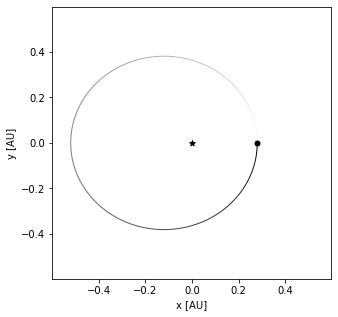

In [7]:
fig = rebound.OrbitPlot(sim, unitlabel='[AU]')

Let's now integrate the orbit for 100 years into the future and check the status again.

In [8]:
sim.integrate(100.*2*np.pi)
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul  9 2019 15:23:25
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	6.2831853071795865e+02
Current timestep:    	0.009478
---------------------------------
<rebound.Particle object, m=1.0 x=0.0015834135970913008 y=66.05416351636514 z=0.0 vx=0.04248320684841354 vy=0.012056475435512045 vz=0.0>
<rebound.Particle object, m=0.05 x=0.2483317280540997 y=66.20648246855777 z=0.0 vx=-0.8496641369682829 vy=1.9668107078717194 vz=0.0>
---------------------------------


In [9]:
for orbit in orbits:
    print(orbit)

<rebound.Orbit instance, a=0.40000000000000013 e=0.30000000000000027 inc=0.0 Omega=0.0 omega=0.0 f=0.0>


As expected, the orbital elements are identical since there is no third body to perturb the system.
Next we'll expand the code a bit by adding a 2nd planet on an inclined orbit we are going to
and save the orbital elements of both planets at each time step.

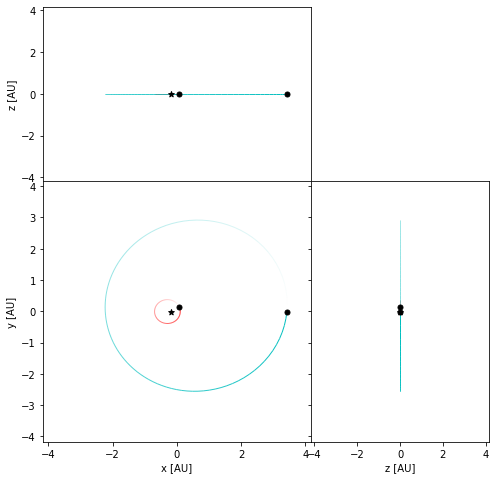

In [10]:
# Add 2nd planet 
sim.add(m=0.05, e=0.1, a=4., primary=sim.particles[0]) 

# For plotting purposes, every time we add an additional body to the
# simulation, we need to move the origin of the coordinate system to
# the cetre of mass
sim.move_to_com()
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', slices=True, color=True)

In [11]:
# specify the integration time step, this should be some fraction of the relevant
# dynamical time in the system, in this case, a fraction of the planet's period
sim.dt = sim.particles[1].P/60. # small fraction of the planet's period

# we'll use the mercurius integrator which combines the IAS15 and WHFast integrators
# in a hybrid scheme
sim.integrator = "whfast"

# number of points at which we save the snapshot of the simulation
N = 1000
tmax = 1e4*(2*np.pi)
# numpy linspace function generates an array of equally spaced numbers on some interval
times = np.linspace(0., tmax, N) 

# Initialize empty arrays in which we'll store the orbital elements at each time step
a = np.zeros((2, N))
e = np.zeros((2, N))

# Iterate over all times in the array and integrate the system forward by dt
for i,t in enumerate(times):
    sim.integrate(t, exact_finish_time=0)
    
    # Compute orbits for each particles and save the values to arrays
    for j, particle in enumerate(sim.particles[1:]): 
        orbit = particle.calculate_orbit()
        a[j, i] = orbit.a
        e[j, i] = orbit.e

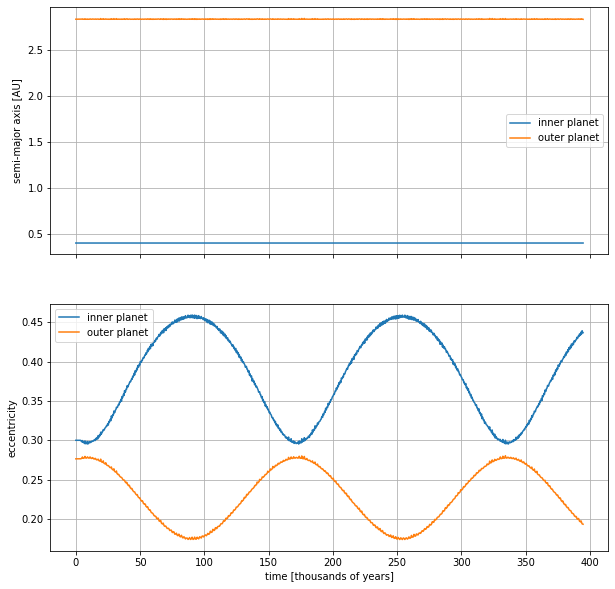

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax[0].plot(times*2*np.pi/1e3, a[0, :], color='C0', label='inner planet')
ax[0].plot(times*2*np.pi/1e3, a[1, :], color='C1', label='outer planet')
ax[1].plot(times*2*np.pi/1e3, e[0, :], color='C0', label='inner planet')
ax[1].plot(times*2*np.pi/1e3, e[1, :], color='C1', label='outer planet')

ax[1].set_xlabel('time [thousands of years]')
ax[0].set_ylabel('semi-major axis [AU]')
ax[1].set_ylabel('eccentricity')

for a in ax.ravel():
    a.legend()
    a.grid()